In [1]:
import sqlalchemy as sal
import pandas as pd
from os.path import join
import numpy as np

import torch

# import data from Relational Database System (RDS) 

In [2]:
%%time

#parameters of the AWS database

endpoint = "capstone.clihskgj8i7s.us-west-2.rds.amazonaws.com"
user="group3"
db="db1"
#pw=getpass.getpass("Enter database password")
pw=open(r'C:\Users\rmartinez4\OneDrive - Illumina, Inc\Desktop\password.txt',"r").read().rstrip()

engine = sal.create_engine('postgresql://%s:%s@%s/%s' % (user, pw, endpoint, db))

query="""
select timestamp, station, avg_speed, total_flow
from traffic_train
where station in (400714, 400743, 400001)
;
"""

df_query_raw=pd.read_sql(query, engine)

print(df_query_raw.shape)
df_query_raw.head()

(156328, 4)
Wall time: 7.3 s


,timestamp,station,avg_speed,total_flow
0,2020-05-08 05:30:00,400001,71.1,354.0
1,2020-05-08 05:30:00,400714,68.5,105.0
2,2020-05-08 05:30:00,400743,67.3,62.0
3,2020-05-08 05:40:00,400714,68.7,202.0
4,2020-05-08 05:40:00,400001,67.1,440.0


## clean data

In [3]:
df_query_raw.isna().sum()

timestamp      0
station        0
avg_speed     17
total_flow    17
dtype: int64

In [4]:
# fill na values with rolling mean

df_query_cleaned = df_query_raw.fillna(df_query_raw.rolling(window=6,min_periods=1).mean())

In [5]:
df_query_cleaned.isna().sum()

timestamp     0
station       0
avg_speed     0
total_flow    0
dtype: int64

## generate seq2seq sequences

In [6]:
def generate_seq2seq_data(df, horizon, window, features):
    
    idx_cols = ['station','timestamp']

    df = df.set_index(idx_cols).sort_values(by=idx_cols)

    features_tensor_list = []
    for f in features:
        print(f)
        
        ts_seq_list = []
        for s in df.index.unique(level=0):
            print(s)
            values = df.loc[s][f].values

            for i in range(len(values)-horizon*2):
                arr = np.array(values[i:i+horizon*2])
                ts_seq_list.append(torch.from_numpy(arr.reshape(horizon*2,1)))

        sequence_tensor = torch.stack(ts_seq_list, dim=0)

        features_tensor_list.append(sequence_tensor)

    return torch.cat(features_tensor_list, dim=2)

In [7]:
%%time
data_seq2seq = generate_seq2seq_data(df_query_cleaned,
                                     horizon=12, 
                                     window=1, 
#                                     features=['avg_speed', 'total_flow'])
                                     features=['avg_speed'])

print(data_seq2seq.shape)

avg_speed
400001
400714
400743
torch.Size([156256, 24, 1])
Wall time: 1.23 s


## train, validation, and test split

In [8]:
# generate x and y vectors

x = data_seq2seq[:, :12, :]
y = data_seq2seq[:, 12:, :]

print(x.shape, y.shape)

torch.Size([156256, 12, 1]) torch.Size([156256, 12, 1])


In [9]:
# define split ratio for train, val and test

num_samples = x.shape[0]
num_test = round(num_samples * 0.2)
num_train = round(num_samples * 0.7)
num_val = num_samples - num_test - num_train

print('total number of samples: {}'.format(num_samples))
print('percentage for train: {}'.format(100*num_train/num_samples))
print('percentage for val: {}'.format(100*num_val/num_samples))
print('percentage for test: {}'.format(100*num_test/num_samples))


total number of samples: 156256
percentage for train: 69.999872004915
percentage for val: 10.000255990169977
percentage for test: 19.999872004915012


In [10]:
# train

x_train = x[:num_train]
y_train = y[:num_train]

# val

x_val = x[num_train: num_train + num_val] 
y_val = y[num_train: num_train + num_val]

# test

x_test = x[-num_test:] 
y_test = y[-num_test:]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

torch.Size([109379, 12, 1]) torch.Size([109379, 12, 1])
torch.Size([15626, 12, 1]) torch.Size([15626, 12, 1])
torch.Size([31251, 12, 1]) torch.Size([31251, 12, 1])


In [11]:
output_dir = './'

for cat in ["train", "val", "test"]:
    
    _x = locals()["x_" + cat] 
    _y = locals()["y_" + cat]
    
    print(cat, "x: ", _x.shape, "y:", _y.shape)
    
    np.savez_compressed(
        join(output_dir, "%s.npz" % cat),
        x=_x,
        y=_y
    )

train x:  torch.Size([109379, 12, 1]) y: torch.Size([109379, 12, 1])
val x:  torch.Size([15626, 12, 1]) y: torch.Size([15626, 12, 1])
test x:  torch.Size([31251, 12, 1]) y: torch.Size([31251, 12, 1])


# train seq2seq model

In [12]:
from torchts.utils import data as utils
from torchts.nn.models.seq2seq import Encoder, Decoder, Seq2Seq 

import time
from pytorch_lightning import Trainer
from pytorch_lightning import loggers as pl_loggers

In [13]:
dataset_dir = './'

# define hyper-parameters

# learning_rate = 0.01 # this parameter is currently hard coded in the optimizer
dropout_rate = 0.8
num_layers = 1
hidden_dim = 64
input_dim = 1
output_dim = 1
horizon = 12
batch_size = 64

In [14]:
%%time
# load train, val and test NPZ files

data = utils.load_dataset(dataset_dir, batch_size=batch_size, test_batch_size=batch_size)

data.keys()

Wall time: 199 ms


dict_keys(['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test', 'train_loader', 'val_loader', 'test_loader', 'scaler'])

In [15]:
# instantiate seq2seq model

encoder = Encoder(input_dim, hidden_dim, num_layers, dropout_rate)
decoder = Decoder(output_dim, hidden_dim, num_layers, dropout_rate)
model = Seq2Seq(encoder, decoder, output_dim, horizon)

c:\users\rmartinez4\anaconda3\envs\deeplearning\lib\site-packages\torch\nn\modules\rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [16]:
# define lightning logger and trainner objects

tb_logger = pl_loggers.TensorBoardLogger('logs/')
trainer = Trainer(max_epochs=1, logger=tb_logger, gpus = 0)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [17]:
# train

start = time.time()
trainer.fit(model, data["train_loader"], data["val_loader"])

print("Training time taken %f"%(time.time() - start), flush=True)


  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | encoder   | Encoder | 34.3 K
2 | decoder   | Decoder | 67.2 K
--------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.406     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

c:\users\rmartinez4\anaconda3\envs\deeplearning\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
c:\users\rmartinez4\anaconda3\envs\deeplearning\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training time taken 131.401881


# predict

In [27]:
# validate

trainer.validate(model, data["val_loader"])
print("Validation Results", vals)

# test

trainer.test(model, data["test_loader"])
print("Test Results", vals)

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'test_loss': 0.053411319851875305, 'val_loss': 0.2998892664909363}
--------------------------------------------------------------------------------
Validation Results [{'val_loss': 0.2998892664909363}]


c:\users\rmartinez4\anaconda3\envs\deeplearning\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.053411319851875305, 'val_loss': 0.2998892664909363}
--------------------------------------------------------------------------------
Test Results [{'val_loss': 0.2998892664909363}]


# visualize test predictions

In [32]:
avg = float(x_test.mean())
std = float(x_test.std())

print(avg, std)

67.06969291649331 2.1476174237638745


In [33]:
def unscale_data(arr, avg, std):
    return arr*std+avg

In [34]:
# find padding

batch_size=64

num_padding_train = (batch_size - len(data["y_train"]) % batch_size) % batch_size
num_padding_val = (batch_size - len(data["y_val"]) % batch_size) % batch_size
num_padding_test = (batch_size - len(data["y_test"]) % batch_size) % batch_size

print('Total Padding No: train {}, val {}, test {}'.format(num_padding_train, num_padding_val, num_padding_test))


Total Padding No: train 61, val 54, test 45


In [45]:
y_true = unscale_data(data["y_test"], avg, std)
y_pred = unscale_data(trainer.test_dataloaders[0].dataset.tensors[0].numpy()[:-num_padding_test], avg, std)

print(y_true.shape)
print(y_pred.shape)


(31251, 12, 1)
(31251, 12, 1)


## single sequences

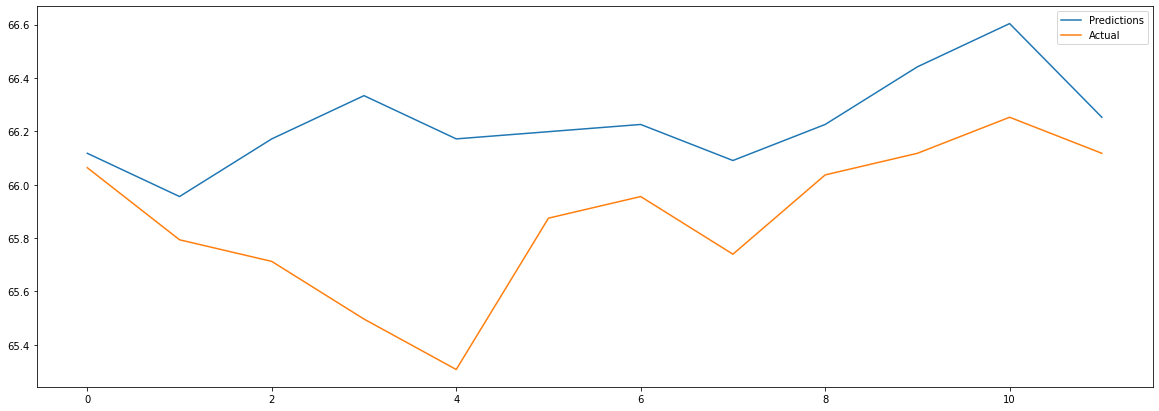

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,7))

sequence_index_to_plot = 7

plt.plot(y_pred[sequence_index_to_plot, :, 0])
plt.plot(y_true[sequence_index_to_plot, :, 0])

plt.legend(['Predictions', 'Actual'], loc='upper right')
plt.rcParams.update({'font.size': 20})


## multiple sequences with single horizon

In [ ]:
plt.figure(figsize=(20,7))

max_sequence_index_to_plot = 100
horizon_to_plot = 5

plt.plot(y_pred[:max_sequence_index_to_plot, horizon_to_plot, 0])
plt.plot(y_true[:max_sequence_index_to_plot, horizon_to_plot, 0])

plt.legend(['Predictions', 'Actual'], loc='upper right')
plt.rcParams.update({'font.size': 20})
